In [1]:
import pickle
from copy import deepcopy

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import numpy as np; np.set_printoptions(suppress=True, linewidth=180)
import pandas as pd; pd.set_option('display.width', 500)
import matplotlib.pyplot as plt

from scipy.optimize import minimize

import os
import ipywidgets as widgets
from ipyfilechooser import FileChooser

from plot_module import plot_ODE, plot_gillespie, plot_simulator_graph, plot_neuron_graph_subset
from sim_param_from_network import names_from_network, gillespie_param_from_network, dataframes_from_network, ODE_from_network, start_state_from_nodes
from neuron_graph_transform import neuron_graph_transform
from neuron_graph_bioparam import add_bioparam_attributes, calculate_influx_efflux ,calculate_target_nss, adjust_soma_birthrate


from simulate import simulate_ode, simulate_gillespie, simulate_tauleaping
from graph_flow_solve import solve_subgraph_flux

In [2]:
# Specify the directory
directory = 'neuron_shape_data'
fc = FileChooser(directory)
display(fc)

FileChooser(path='/home/daniel/Projects/2023_Jones_Lab_mtDNA/SSD/SSD_Neuron/neuron_shape_data', filename='', t…

In [3]:
#temp_fp = '/home/daniel/Projects/2023_Jones_Lab_mtDNA/SSD/SSD_Neuron/neuron_shape_data/m_hippocampus_NMO_97827.pkl'
temp_fp = '/home/daniel/Projects/2023_Jones_Lab_mtDNA/SSD/SSD_Neuron/neuron_shape_data/h_cerebellum_interneuron_NMO_32551.pkl'

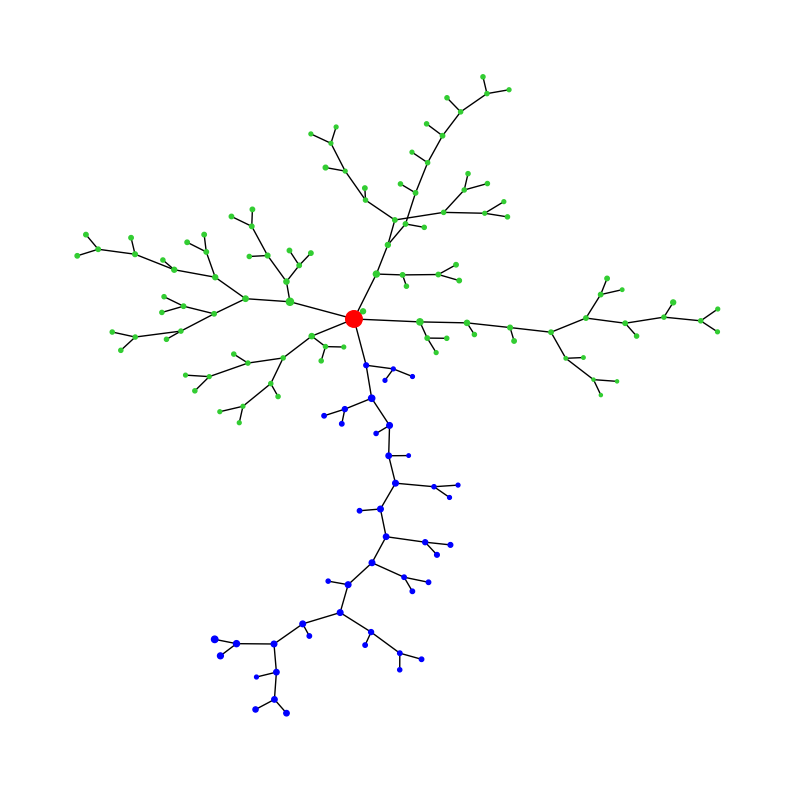

In [4]:
#file_path = fc.selected
file_path = temp_fp
assert file_path != None, 'No file selected!'
assert os.path.isfile(file_path), f'"{file_path}" does not point to a file!'

file_name = os.path.basename(file_path)
name, extension = os.path.splitext(file_name)
assert extension == '.pkl', f'selected file must be a pickled nxgraph!'


with open(file_path, 'rb') as f:
    imported_neuron_graph = pickle.load(f)    

plot_neuron_graph_subset(imported_neuron_graph)

In [5]:
DELTA = 0.5
DEATH_RATE = 0.4
SWITCH_RATE_AR = 0.01
SWITCH_RATE_RA = 0.01

TRANSP_SPEED = 14000

SOMA_CB = 1.0
SOMA_BR = 3.2
SOMA_NSS = 500
SOMA_DIFFUSION = 0.4
SOMA_MITO_DENSITY = 2 # number of mt/um^3 of volume


AXON_MITO_DENSITY = 2 # number of mt/um^3 of volume
AXON_TRNSP_ANT = 8
AXON_TRNSP_RET = 6

# AXON_TERMINAL_INFLUX = 2*DEATH_RATE*AXON_NODE_POP
# AXON_TERMINAL_EFFLUX = DEATH_RATE*AXON_NODE_POP


DENDRITE_MITO_DENSITY = 2 # number of mt/um^3 of volume

bio_param = {
    # global parameters    
    'delta': DELTA, 
    'switch_rate_ar': SWITCH_RATE_AR,
    'switch_rate_ra': SWITCH_RATE_RA,
    
    # soma parameters
    'soma_death_rate': DEATH_RATE, 
    'soma_mito_density': SOMA_MITO_DENSITY,
    'soma_cb': SOMA_CB, 
    'soma_br': SOMA_BR, 
    'soma_diffusion': SOMA_DIFFUSION,
    'soma_nss': None,
    
    # axon parameters
    'axon_death_rate': DEATH_RATE, 
    'axon_mito_density':AXON_MITO_DENSITY,
    'axon_nss': None,
    'axon_transp_speed': TRANSP_SPEED,
    'axon_terminal_influx': None,
    'axon_terminal_efflux': None,

    # dendrite paramters
    'dendrite_death_rate': DEATH_RATE, 
    'dendrite_mito_density': SOMA_MITO_DENSITY,
    'dendrite_nss': None,
    'dendrite_transp_speed': TRANSP_SPEED,
    'dendrite_terminal_influx': None,
    'dendrite_terminal_efflux': None,
    }


> Inferring target node populations per branch type from section volumes.
total soma volume is 1152.59 µm^3 spread across 1 node(s). At a density of 2 mt/µm^3, this gives a target pop. of 2305 mt/node
total axon volume is 2748.1 µm^3 spread across 45 node(s). At a density of 2 mt/µm^3, this gives a target pop. of 122 mt/node
total dendrite volume is 2698.85 µm^3 spread across 107 node(s). At a density of 2 mt/µm^3, this gives a target pop. of 50 mt/node

> Inferring net influx and efflux at at axon and dendrite terminals.
at a death rate of 0.4, a target axon pop. of 122, requires an influx of 97.6 mt and an outflow of 48.8 mt
at a death rate of 0.4, a target dendrite pop. of 50, requires an influx of 40.0 mt and an outflow of 20.0 mt

>> Transforming input graph:
> The undirected input graph has 153 nodes, and 152 edges. Found 6 branches:
dendrite of 35 nodes, total volume is 634.51 um^3
dendrite of 25 nodes, total volume is 438.27 um^3
dendrite of 15 nodes, total volume is 349.48 um

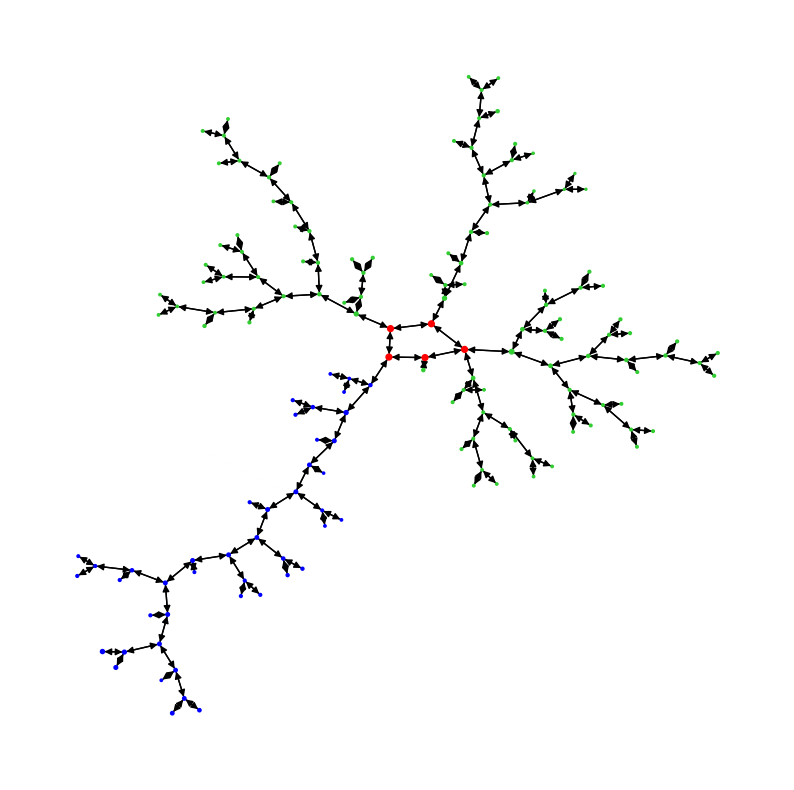

In [6]:
# calculate the target nss values, based on the mitochondrial densities, volumes, and node counts of each respective section
bio_param = calculate_target_nss(imported_neuron_graph, bio_param)
# calculate the target net influx and efflux at axon and soma terminals
bio_param = calculate_influx_efflux(imported_neuron_graph, bio_param)

# transform the graph 
G, G_subgraphs = neuron_graph_transform(imported_neuron_graph, transform_type='bidirect', n_soma_nodes=5)

# add biological parameters
G = add_bioparam_attributes(G, bio_param)


# print('\n> Edges in the transformed graph:')
#for u, v, data in G.edges(data = True): print(f'{u}-{v}: {data}')
# print('\n> Nodes in the transformed graph:')
# for node, data in G.nodes(data = True): print(f'{node}: {data}')

plot_neuron_graph_subset(G)


>>> Solving subgraphs flows...

>> Solving subgraph 0


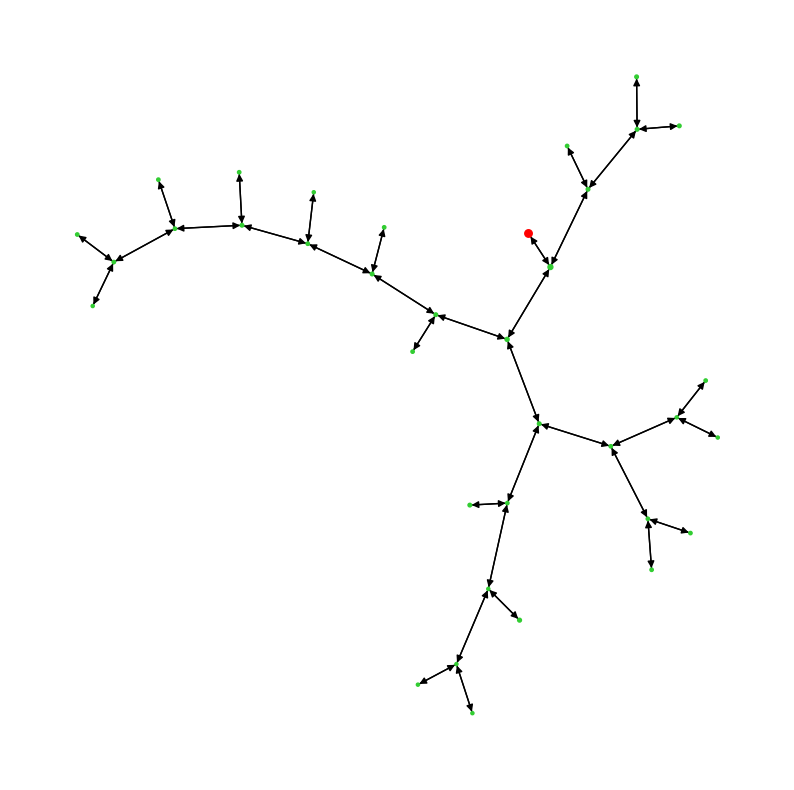

> Flux dataframe with unknowns:
        u      v direction flux_mat_i_j reverse_pair  u_popsize flux_rate    net_flux
0   D161B  D143B   reverse      (0, 16)                    50.0       0.4        20.0
1   D275B  D264B   reverse      (1, 35)                    50.0      r[0]   50.0*r[0]
2   D275B  D283B   forward       (1, 5)            9       50.0      r[1]   50.0*r[1]
3   D275B  D314B   forward      (1, 25)           51       50.0      r[2]   50.0*r[2]
4   D442B  D373B   reverse      (2, 15)                    50.0       0.4        20.0
..    ...    ...       ...          ...          ...        ...       ...         ...
65  D309B  D283B   reverse      (33, 5)                    50.0       0.4        20.0
66  D246B  D233B   reverse      (34, 4)                    50.0       0.4        20.0
67  D264B   D94B   reverse     (35, 17)                    50.0     r[31]  50.0*r[31]
68  D264B  D275B   forward      (35, 1)            1       50.0     r[32]  50.0*r[32]
69  D264B  D367B   for

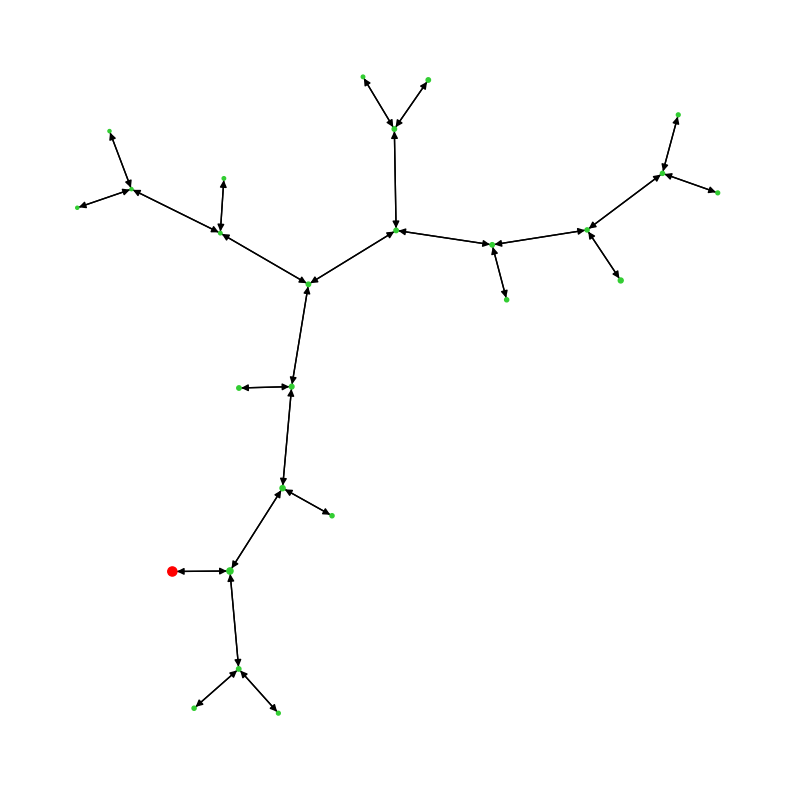

> Flux dataframe with unknowns:
        u      v direction flux_mat_i_j reverse_pair  u_popsize flux_rate     net_flux
0   D713B  D685B   reverse      (0, 17)                    50.0       0.4         20.0
1   D613B  D611B   reverse      (1, 21)                    50.0      r[0]    50.0*r[0]
2   D613B  D622B   forward       (1, 2)            4       50.0       0.8         40.0
3   D613B  D624B   forward       (1, 5)           11       50.0      r[1]    50.0*r[1]
4   D622B  D613B   reverse       (2, 1)                    50.0       0.4         20.0
5   D582B  D519B   reverse       (3, 9)                    50.0      r[2]    50.0*r[2]
6   D582B  D601B   forward      (3, 10)           22       50.0       0.8         40.0
7   D582B  D608B   forward      (3, 20)           40       50.0       0.8         40.0
8   D644B  D630B   reverse      (4, 25)                    50.0      r[3]    50.0*r[3]
9   D644B  D649B   forward      (4, 12)           24       50.0      r[4]    50.0*r[4]
10  D644B  

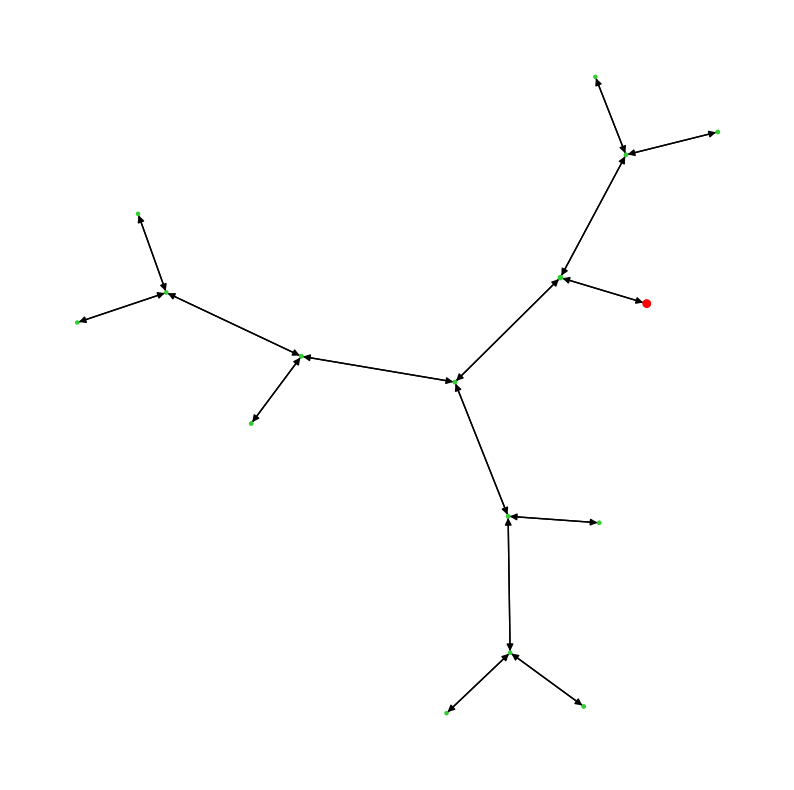

> Flux dataframe with unknowns:
         u       v direction flux_mat_i_j reverse_pair  u_popsize flux_rate    net_flux
0    D836B   D819B   reverse      (0, 14)                    50.0       0.4        20.0
1    D797B   D819B   forward      (1, 14)           26       50.0      r[0]   50.0*r[0]
2    D797B   D889B   forward       (1, 4)            6       50.0      r[1]   50.0*r[1]
3    D797B     S2B   reverse       (1, 8)                    50.0      r[2]   50.0*r[2]
4    D944B   D933B   reverse      (2, 13)                    50.0       0.4        20.0
5    D977B   D933B   reverse      (3, 13)                    50.0       0.4        20.0
6    D889B   D797B   reverse       (4, 1)                    50.0      r[3]   50.0*r[3]
7    D889B   D894B   forward      (4, 12)           20       50.0      r[4]   50.0*r[4]
8    D889B   D992B   forward      (4, 11)           17       50.0      r[5]   50.0*r[5]
9   D1010B   D992B   reverse      (5, 11)                    50.0      r[6]   50.0*r[6]


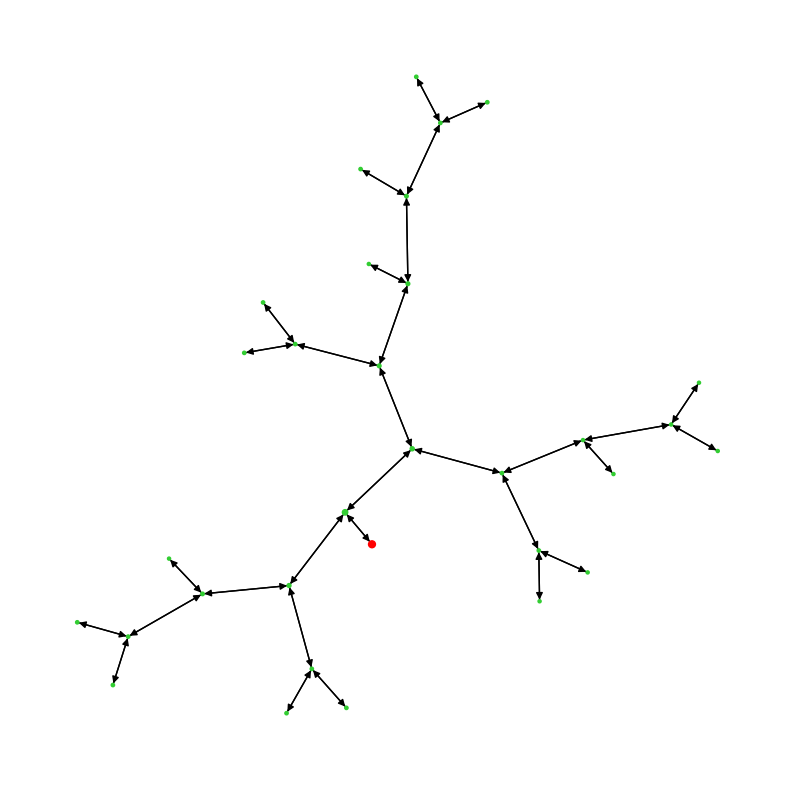

> Flux dataframe with unknowns:
         u       v direction flux_mat_i_j reverse_pair  u_popsize flux_rate    net_flux
0   D1165B  D1128B   reverse      (0, 19)                    50.0      r[0]   50.0*r[0]
1   D1165B  D1179B   forward      (0, 18)           34       50.0       0.8        40.0
2   D1165B  D1198B   forward       (0, 2)            6       50.0       0.8        40.0
3   D1321B  D1081B   reverse      (1, 13)                    50.0      r[1]   50.0*r[1]
4   D1321B  D1334B   forward      (1, 27)           51       50.0      r[2]   50.0*r[2]
..     ...     ...       ...          ...          ...        ...       ...         ...
57  D1661B  D1687B   forward     (30, 11)           21       50.0       0.8        40.0
58  D1661B  D1699B   forward     (30, 20)           38       50.0       0.8        40.0
59  D1557B  D1541B   reverse     (31, 12)                    50.0     r[29]  50.0*r[29]
60  D1557B  D1586B   forward      (31, 5)           13       50.0       0.8        40.0


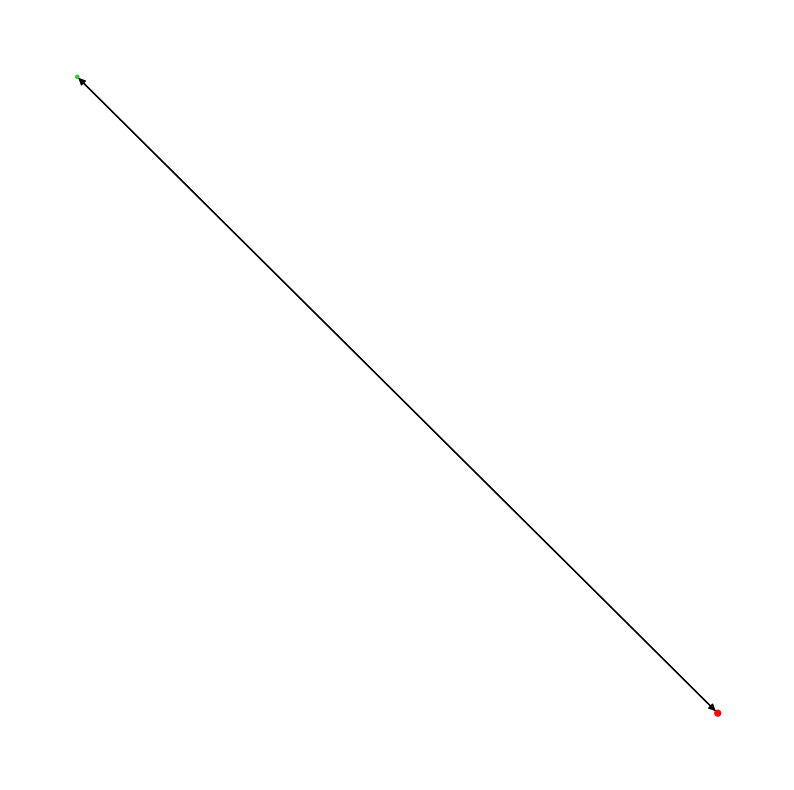

> Flux dataframe with unknowns:
        u       v direction flux_mat_i_j reverse_pair  u_popsize flux_rate    net_flux
0  D1703B     S3B   reverse       (0, 1)                    50.0      r[0]   50.0*r[0]
1     S3B  D1703B   forward       (1, 0)            0      461.0      r[1]  461.0*r[1]

> Optimizing flux values...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 48.57142857219262
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2

> Solved net flux matrix:
[[ 0.   14.28]
 [34.3   0.  ]]

>> Solving subgraph 5


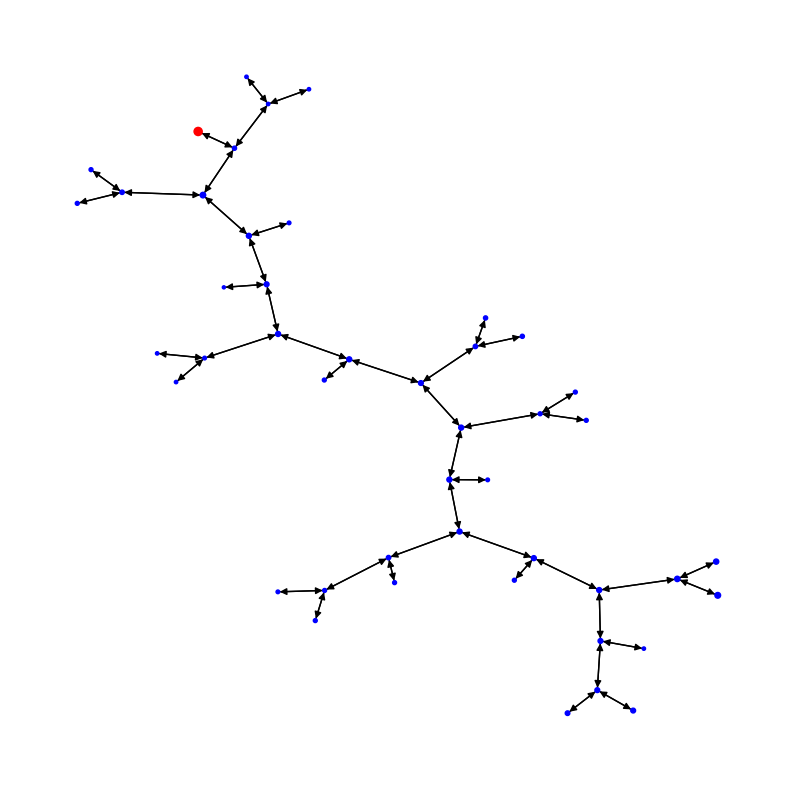

> Flux dataframe with unknowns:
         u       v direction flux_mat_i_j reverse_pair  u_popsize flux_rate    net_flux
0   A2326B  A2289B   reverse      (0, 13)                   122.0      r[0]  122.0*r[0]
1   A2326B  A2336B   forward       (0, 8)           20      122.0       0.8        97.6
2   A2326B  A2344B   forward      (0, 14)           34      122.0       0.8        97.6
3   A2171B  A2164B   reverse      (1, 21)                   122.0       0.4        48.8
4   A2195B  A2164B   reverse      (2, 21)                   122.0       0.4        48.8
..     ...     ...       ...          ...          ...        ...       ...         ...
85  A2083B  A2055B   reverse     (41, 34)                   122.0       0.4        48.8
86  A2210B  A2202B   reverse     (42, 25)                   122.0       0.4        48.8
87  A1947B  A1937B   reverse     (43, 23)                   122.0       0.4        48.8
88  A1917B  A1898B   reverse     (44, 15)                   122.0       0.4        48.8


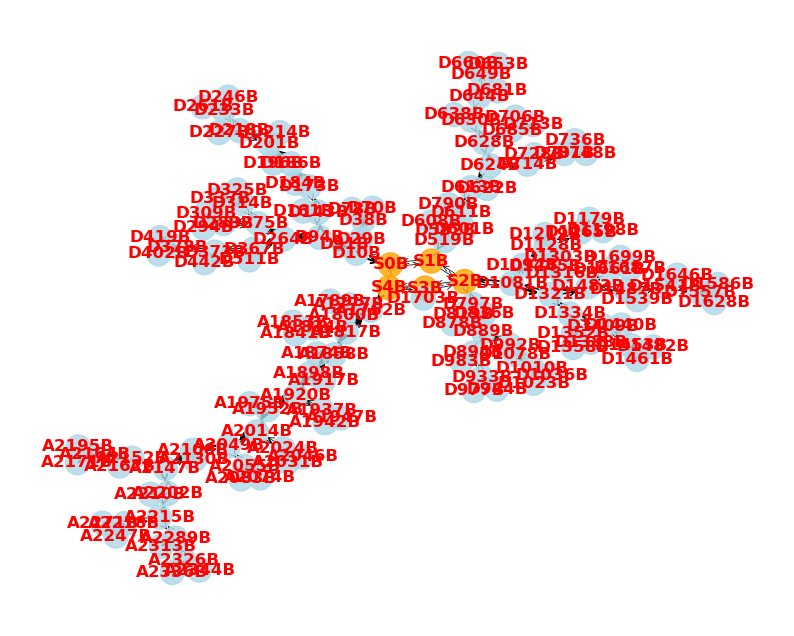

In [7]:
print(f"\n>>> Solving subgraphs flows...")

outflow = 0
for i, subgraph_nodes in enumerate(G_subgraphs):
    print(f"\n>> Solving subgraph {i}")
    H = G.subgraph(subgraph_nodes)
    plot_neuron_graph_subset(H)
    flux_dict, net_soma_flux = solve_subgraph_flux(H)
    outflow += net_soma_flux
    nx.set_edge_attributes(G, flux_dict, 'rate')
print("\n<<< Finished solving >>>\n")
    
G, bio_param = adjust_soma_birthrate(G, bio_param, outflow)
    
plot_simulator_graph(G)

In [18]:
TIME_POINTS = np.linspace(0, 365, 1001)
VARS, NODES = names_from_network(G)
START_STATE = start_state_from_nodes(G, heteroplasmy=0.2, delta=DELTA)

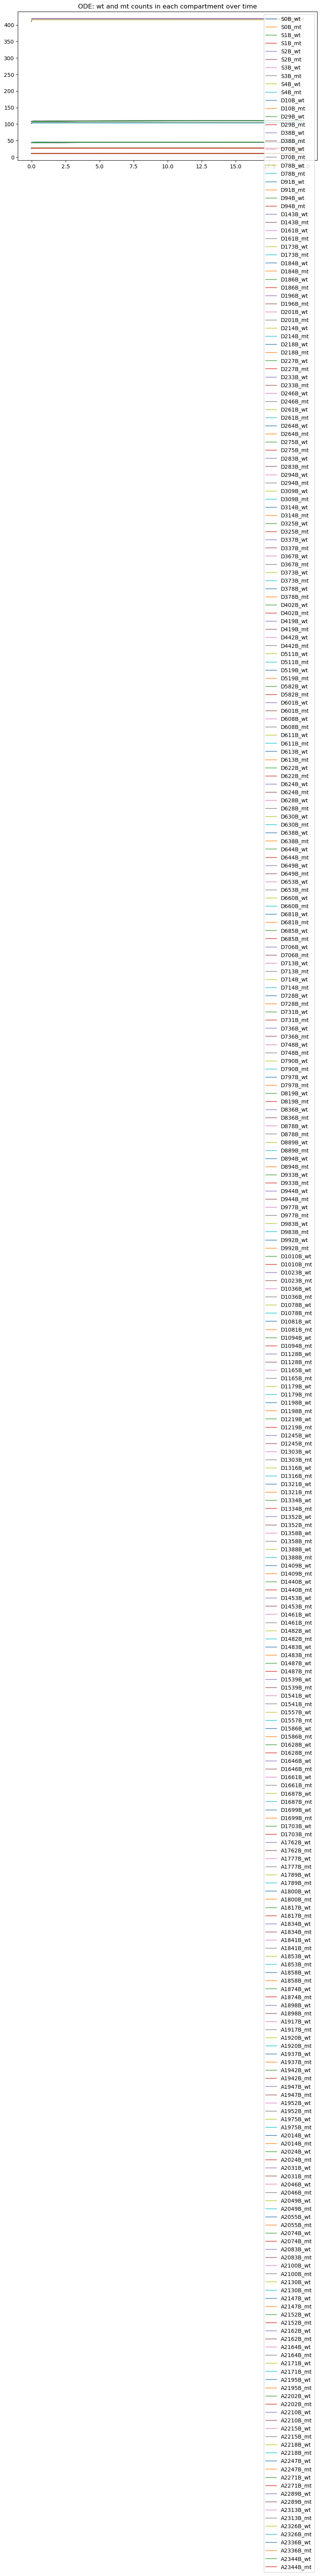

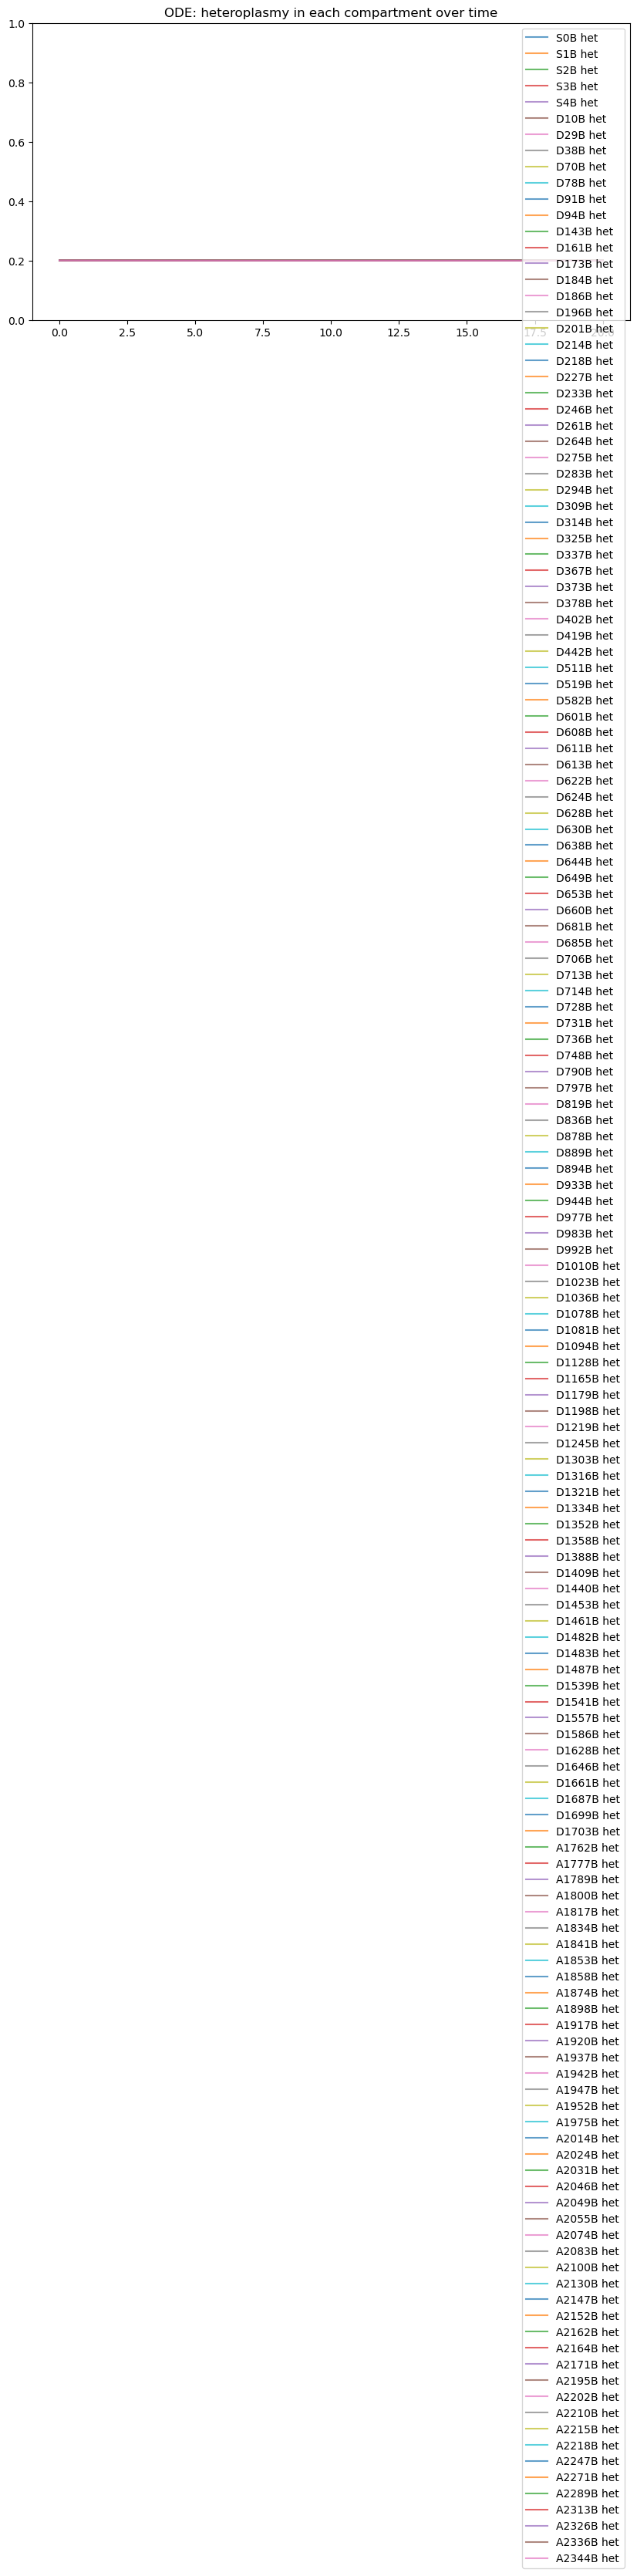

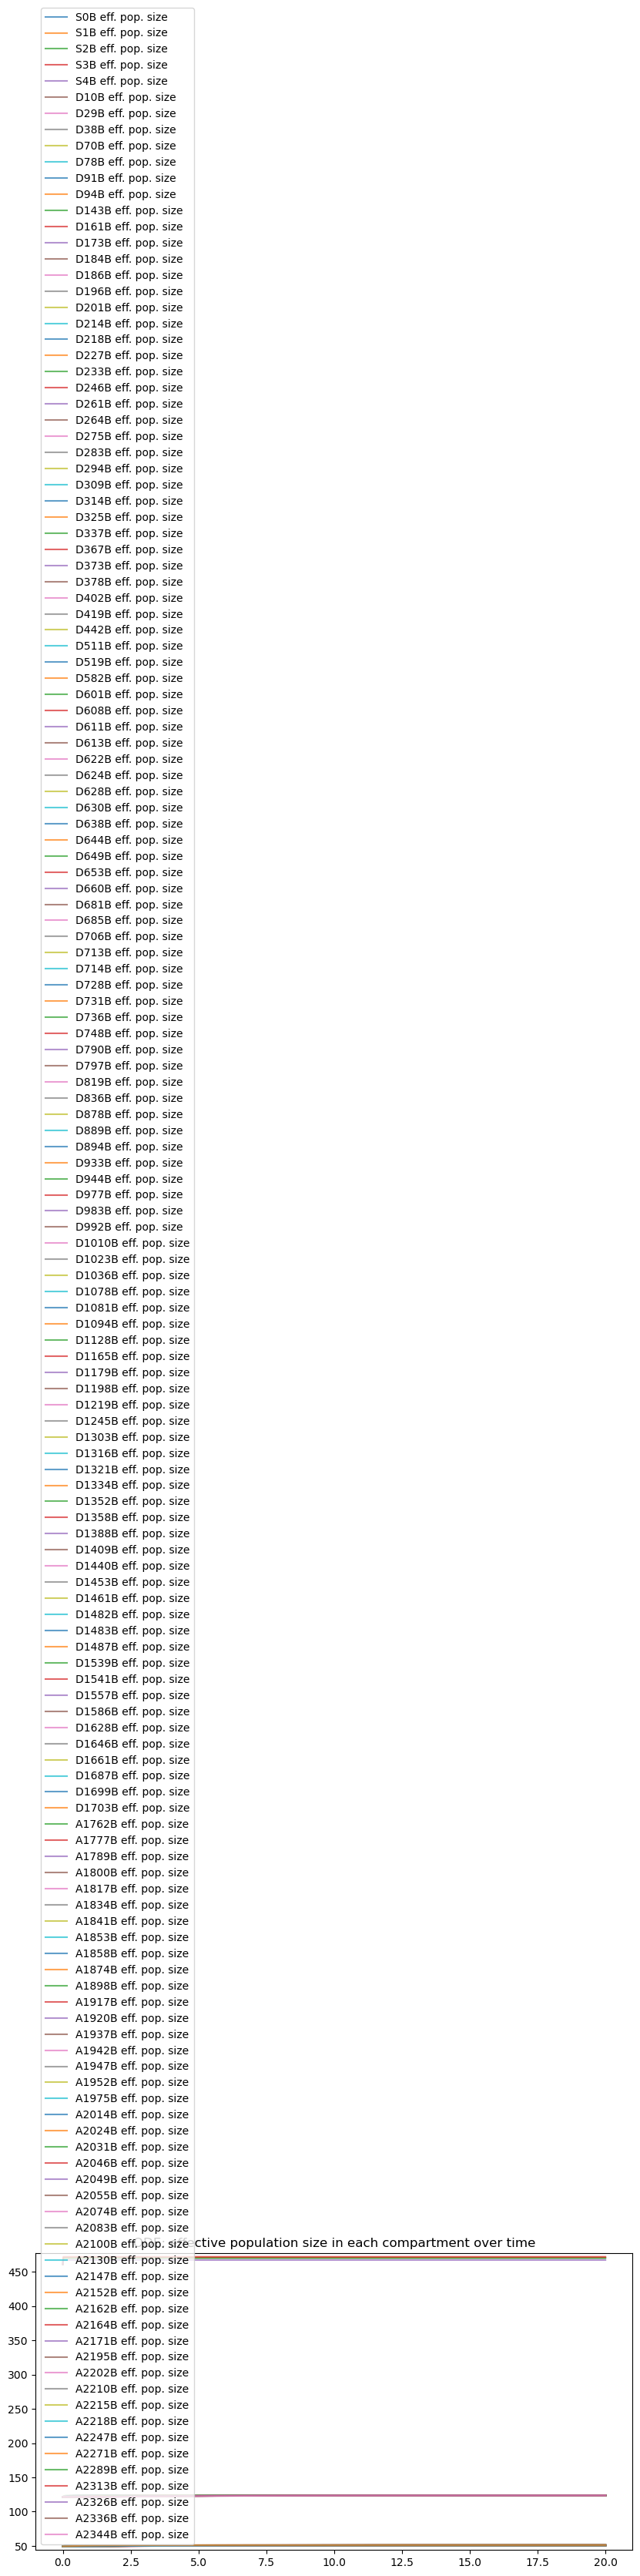

> Final counts of mt and wt in each compartment:
S0B_wt	418.3997	
S0B_mt	104.1703	
S1B_wt	418.7866	
S1B_mt	104.2666	
S2B_wt	417.9796	
S2B_mt	104.0657	
S3B_wt	419.7085	
S3B_mt	104.4961	
S4B_wt	415.5219	
S4B_mt	103.4538	
D10B_wt	45.3789	
D10B_mt	11.2981	
D29B_wt	45.3791	
D29B_mt	11.2982	
D38B_wt	45.3794	
D38B_mt	11.2982	
D70B_wt	45.38	
D70B_mt	11.2984	
D78B_wt	45.38	
D78B_mt	11.2984	
D91B_wt	45.3792	
D91B_mt	11.2982	
D94B_wt	45.379	
D94B_mt	11.2981	
D143B_wt	45.379	
D143B_mt	11.2981	
D161B_wt	45.379	
D161B_mt	11.2982	
D173B_wt	45.379	
D173B_mt	11.2982	
D184B_wt	45.3791	
D184B_mt	11.2982	
D186B_wt	45.3791	
D186B_mt	11.2982	
D196B_wt	45.3793	
D196B_mt	11.2982	
D201B_wt	45.3793	
D201B_mt	11.2982	
D214B_wt	45.3797	
D214B_mt	11.2983	
D218B_wt	45.3797	
D218B_mt	11.2983	
D227B_wt	45.3805	
D227B_mt	11.2985	
D233B_wt	45.3807	
D233B_mt	11.2985	
D246B_wt	45.3822	
D246B_mt	11.2989	
D261B_wt	45.3822	
D261B_mt	11.2989	
D264B_wt	45.379	
D264B_mt	11.2982	
D275B_wt	45.3792	
D275B_mt	11.2982	
D283B_wt	45.

In [9]:
ODE_model = ODE_from_network(G, prnt=False)
plot_ODE(simulate_ode(ODE_model, TIME_POINTS, START_STATE), TIME_POINTS, DELTA, VARS, NODES)

In [19]:
GILL_PARAM = gillespie_param_from_network(G)
gillespie_results = simulate_gillespie(GILL_PARAM, TIME_POINTS, START_STATE, replicates=10)
plot_gillespie(gillespie_results, TIME_POINTS, DELTA, VARS, NODES)

simulating...


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

simulating...




  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:46<06:59, 46.62s/it]

 20%|██        | 2/10 [00:48<02:42, 20.30s/it]

 40%|████      | 4/10 [00:49<00:46,  7.75s/it]

 50%|█████     | 5/10 [00:49<00:27,  5.49s/it]

 60%|██████    | 6/10 [00:49<00:15,  3.88s/it]

 70%|███████   | 7/10 [00:50<00:08,  2.93s/it]

 80%|████████  | 8/10 [00:50<00:04,  2.10s/it]

 90%|█████████ | 9/10 [00:50<00:01,  1.51s/it]

  0%|          | 0/10 [04:34<?, ?it/s]


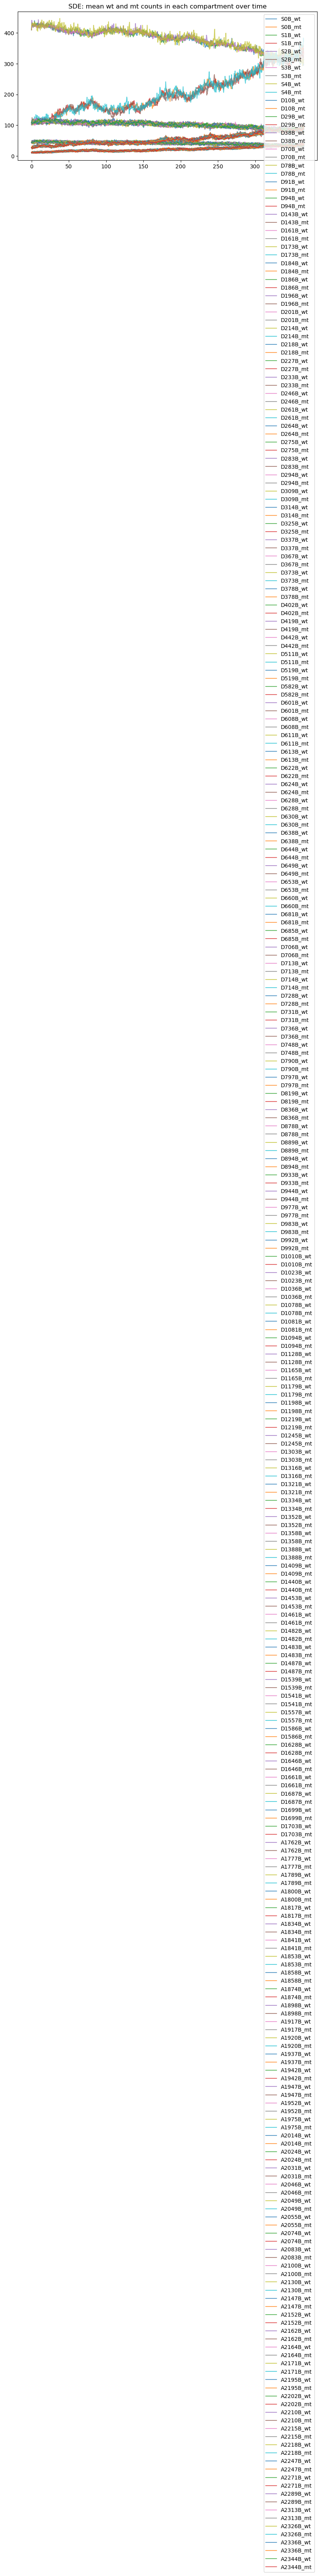

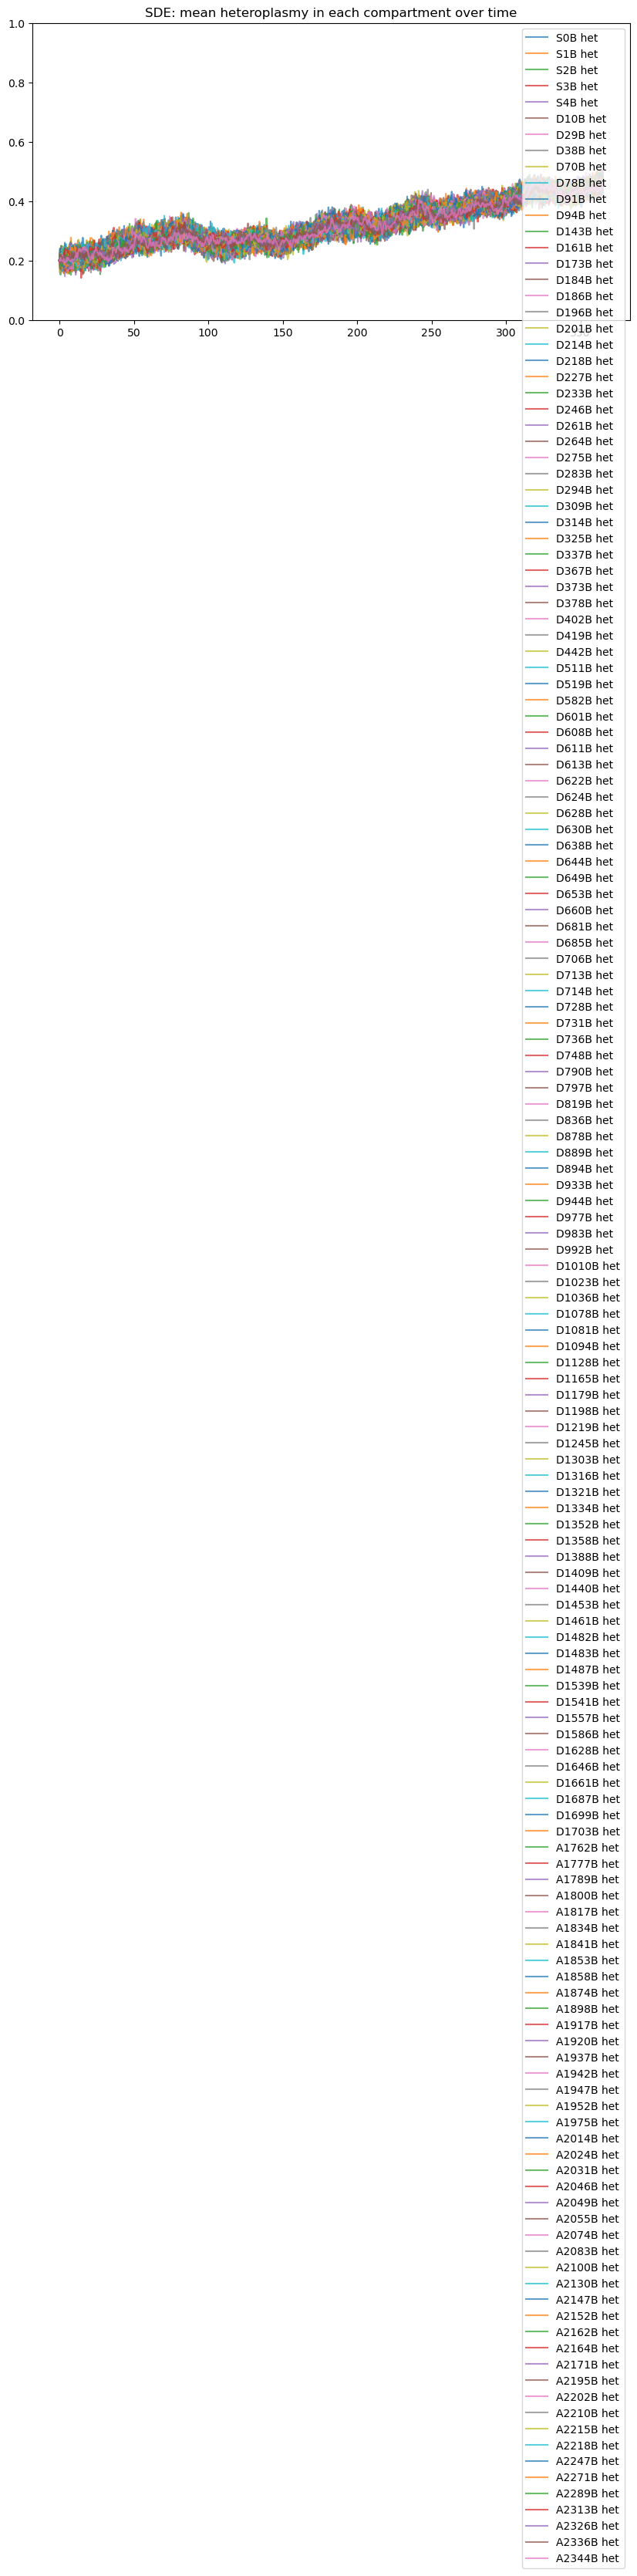

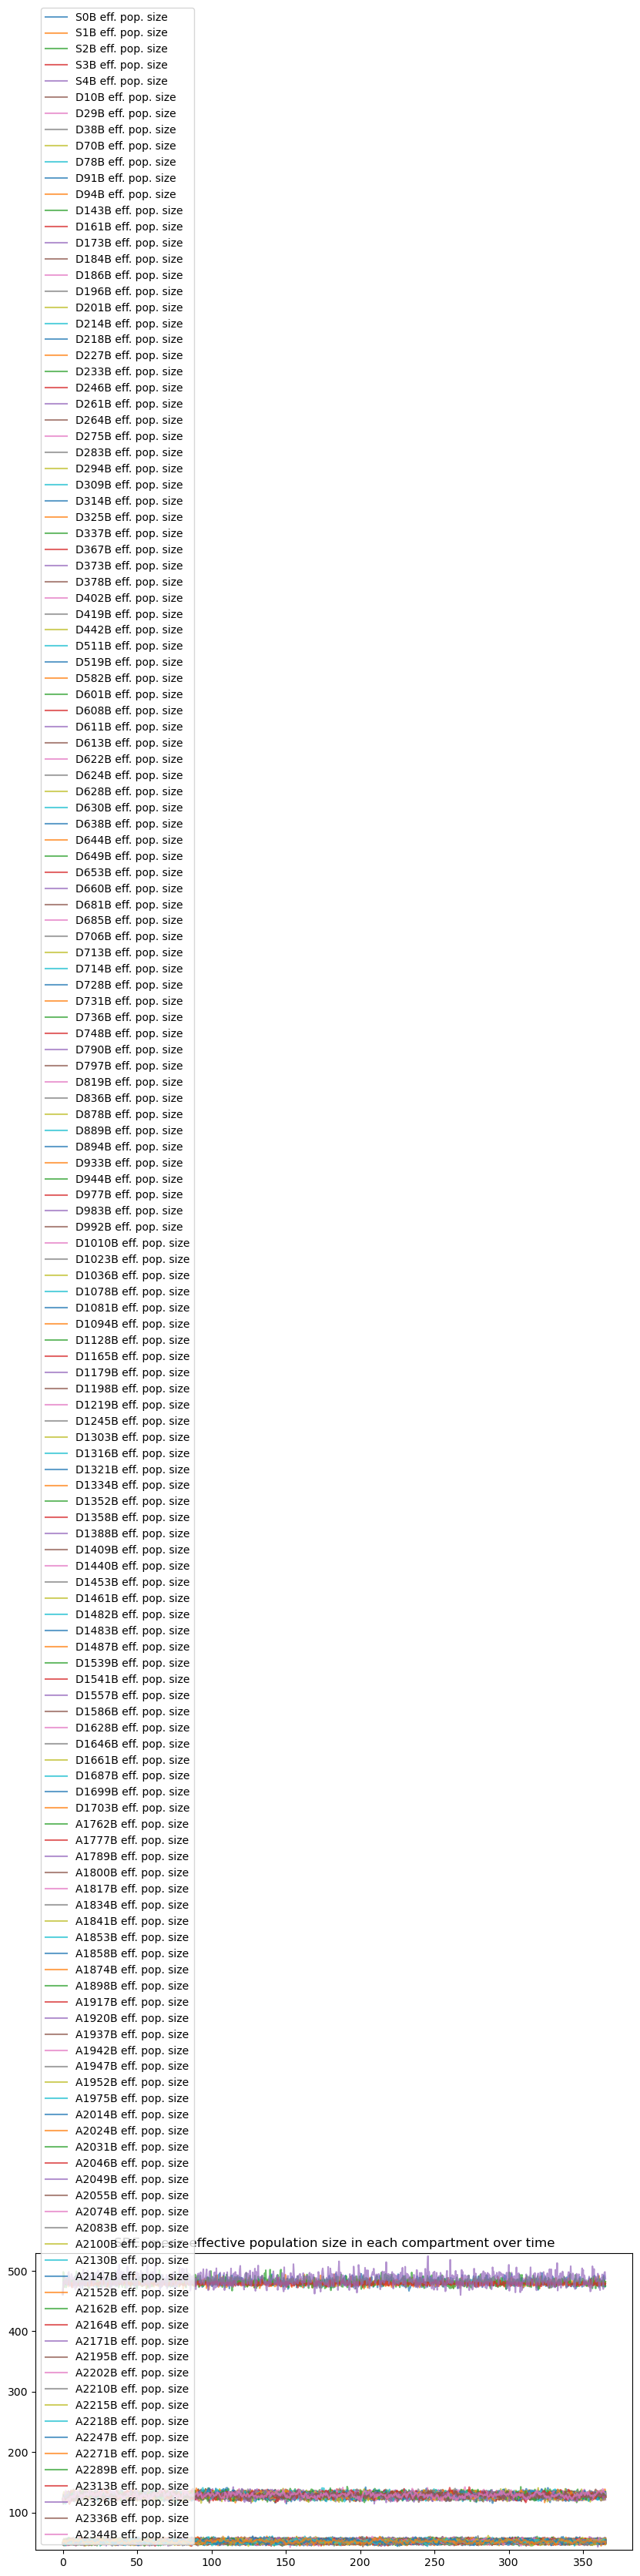

> Final mean counts of mt and wt in each compartment:
S0B_wt	296.3	
S0B_mt	357.0	
S1B_wt	313.1	
S1B_mt	337.9	
S2B_wt	315.3	
S2B_mt	333.1	
S3B_wt	304.2	
S3B_mt	349.4	
S4B_wt	300.6	
S4B_mt	372.2	
D10B_wt	32.0	
D10B_mt	40.3	
D29B_wt	35.8	
D29B_mt	39.8	
D38B_wt	32.4	
D38B_mt	35.4	
D70B_wt	32.0	
D70B_mt	39.7	
D78B_wt	31.5	
D78B_mt	37.8	
D91B_wt	34.7	
D91B_mt	38.3	
D94B_wt	33.6	
D94B_mt	35.0	
D143B_wt	33.4	
D143B_mt	40.3	
D161B_wt	31.8	
D161B_mt	40.2	
D173B_wt	33.6	
D173B_mt	37.7	
D184B_wt	33.0	
D184B_mt	36.6	
D186B_wt	33.8	
D186B_mt	34.2	
D196B_wt	34.4	
D196B_mt	37.2	
D201B_wt	33.0	
D201B_mt	37.1	
D214B_wt	37.7	
D214B_mt	37.6	
D218B_wt	31.6	
D218B_mt	36.5	
D227B_wt	37.2	
D227B_mt	36.6	
D233B_wt	32.2	
D233B_mt	37.0	
D246B_wt	34.8	
D246B_mt	36.5	
D261B_wt	32.6	
D261B_mt	40.1	
D264B_wt	28.8	
D264B_mt	39.4	
D275B_wt	32.7	
D275B_mt	38.9	
D283B_wt	38.3	
D283B_mt	39.3	
D294B_wt	32.9	
D294B_mt	40.1	
D309B_wt	34.9	
D309B_mt	38.6	
D314B_wt	34.1	
D314B_mt	37.6	
D325B_wt	33.7	
D325B_mt	35.9	
D337B_wt	3

In [20]:
TAU_PARAM = gillespie_param_from_network(G)
tauleaping_results = simulate_tauleaping(TAU_PARAM, TIME_POINTS, START_STATE, replicates=10, timestep=0.01)
plot_gillespie(tauleaping_results, TIME_POINTS, DELTA, VARS, NODES)

In [12]:
temp_timestep = 0.1
max_change_per_timestep = 10
while max(np.round(np.array(ODE_model(0, START_STATE))*temp_timestep, 2)) > max_change_per_timestep:
    temp_timestep = np.round(temp_timestep/2, 5)
temp_timestep

0.00156

In [13]:
TAU_PARAM['gillespie']['reactions'].shape

(952, 314)